## Airbnb is one of the most famous platforms that operates an online marketplace for lodging|, primarily homestays for vacation rentals, and tourism activities.

### We have Airbnb Seattle data of the listings, calendar of bookings, and reviews of guests. Those data were recorded from the beginning of 2016 until January 2017 (listings and calendars), while review data were recorded from 2010 until the end of 2015.


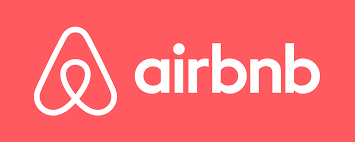

### This Notebook will aim to answer 4 questions:

### 1- Which month has the highest number of bookings?

### 2- Which features have the highest impact on prices?

### 3- Which Amenities are the most important?

### 4- Can we tell if a reviewer is being unfair?


### We will also make machine learning models too


### Importing Liburaries

In [1]:
#Imports

#Import linear algebra and data manipulation
import numpy as np
import pandas as pd

#Import plotting packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Import machine learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor


from sklearn.model_selection import train_test_split #split
from sklearn.metrics import r2_score, mean_squared_error #metrics

## Data Understanding

#### Listings Data

In [2]:
# read the listing dataset
listingsDf = pd.read_csv('listings.csv')


# The number of listings, hosts and neighbourhoods
listingsCount = len(listingsDf.id)
hostsCount = len(listingsDf.host_id.unique())
neighbourhoodsCount = len(listingsDf.neighbourhood.unique())
print('The number of listings in the dataset is %d listings provided by %d hosts in %d different neighbourhoods.' % (listingsCount,hostsCount,neighbourhoodsCount))

The number of listings in the dataset is 3818 listings provided by 2751 hosts in 82 different neighbourhoods.


#### Calendar Data

In [3]:
#read the calendar dataset
calendarDf = pd.read_csv('calendar.csv')

calendarDf.head()
# The average number of available listings per day 
averageAvailableListings = len(calendarDf[calendarDf.available == 't'])/len(calendarDf.listing_id.unique())
print('There is an average of %d listings available per day.' % (averageAvailableListings))

There is an average of 244 listings available per day.


#### Reviews Data

In [4]:
#read the reviews dataset
reviewsDf = pd.read_csv('reviews.csv')
reviewsDf.head()

# The number of reviews and the number of listings were reviewd
reviewsCount = len(reviewsDf[reviewsDf.comments.notnull()].comments)
listingsRCount = len(reviewsDf[reviewsDf.comments.notnull()].listing_id.unique())
print('There are %d reviews on %d listings.'%(reviewsCount,listingsRCount))

There are 84831 reviews on 3191 listings.


### Handeling missing data

#### Listings Data

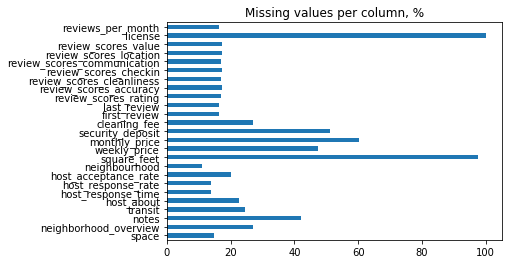

In [5]:
# What columns have more than 10% missing values?
listingMissingDf = listingsDf.isnull().mean()*100
listingMissingDf = listingMissingDf[listingMissingDf > 10]

# plot the results
listingMissingDf.plot.barh(title='Missing values per column, %')

# I chose more than 10% because I will only consider those to be dropped for the lack of data

#### Calendar Data

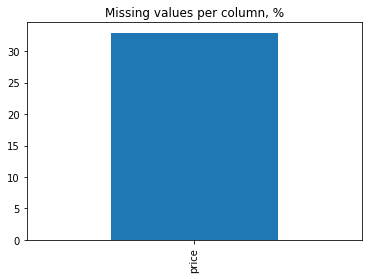

In [6]:
# What columns have more than 10% missing values?
calendarMissingDf = calendarDf.isnull().mean() * 100
calendarMissingDf = calendarMissingDf[calendarMissingDf > 10]

# plot the results
calendarMissingDf.plot.bar(title='Missing values per column, %')

In [7]:
# The diagram aboce indicates that 32% of price column values are missing and we will check now if this is because 
# the listing was available or not?
calendarDfWhenAvailable = calendarDf[calendarDf.available == 't']
calendarMissingDfWhenAvailable = calendarDfWhenAvailable.isnull().mean() * 100
calendarMissingDfWhenAvailable.price

#As we can see, yes the 32% missing values were becuse of the unavailability of the listings


0.0

### Merging listings dataframe and Calendar dataframe

In [8]:
#merging listings with calendar.
listingsDf = listingsDf.rename(index=str, columns={"id": "listing_id"})
df = pd.merge(calendarDf, listingsDf, on = 'listing_id')

In [9]:
# We will drop irrelevant columns and columns that has missing values
rowsBefore = df.shape[0]
columnsBefore = df.shape[1]
df.drop(axis = 1, labels = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 
       'host_has_profile_pic', 
       'street',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 
       'is_location_exact', 
       'calendar_last_scraped',
       'first_review', 'last_review', 
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'requires_license',
       'license', 'jurisdiction_names', 'instant_bookable',
        'calculated_host_listings_count',
       'reviews_per_month','minimum_nights', 'maximum_nights','available','price_y', 'cleaning_fee', 'guests_included',
       'extra_people', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365','require_guest_profile_picture',
       'require_guest_phone_verification' ],inplace = True)
# Drop columns with more than 40% missingvalues
# Columns that have more than 40% missing values will be dropped, this is because we can either fill them
# with values that would lead us to having 40% of it as not actually a true data which will affect the results
# or we can only drop the rows that has missing values which will result in losing at least 40% of our data
df40Missing = df.isnull().mean()*100
df40Missing = df40Missing[df40Missing > 40]
df40Missing = list(df40Missing.index)
df.drop(axis = 1 , labels = df40Missing,inplace = True)
#Drop rows with missing values
df.dropna(subset= ['listing_id', 'date','price_x','accommodates','bathrooms','bedrooms'],  inplace = True)

rowsAfter = df.shape[0]
columnsAfter = df.shape[1]



print('The dataframe had %d columns and %d rows before, now it has %d columns and %d rows' % (columnsBefore,rowsBefore,columnsAfter,rowsAfter))


The dataframe had 95 columns and 1393570 rows before, now it has 26 columns and 927736 rows


#### Reviews Data

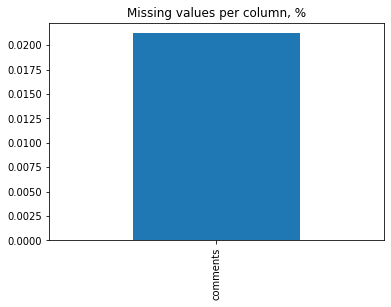

In [10]:
# What columns have missing values?
reviewsMissingDf = reviewsDf.isnull().mean() * 100
reviewsMissingDf = reviewsMissingDf[reviewsMissingDf > 0]

# plot the results
reviewsMissingDf.plot.bar(title = 'Missing values per column, %')

#As we can see the is less than 1% of comments are missing

In [11]:
# Dropping rows with missing values
rowsBefore = reviewsDf.shape[0]
columnsBefore = reviewsDf.shape[1]
reviewsDf.dropna(inplace=True)
rowsAfter = reviewsDf.shape[0]
columnsAfter = reviewsDf.shape[1]

print('The dataframe had %d columns and %d rows before, now it has %d columns and %d rows' % (columnsBefore,rowsBefore,columnsAfter,rowsAfter))

The dataframe had 6 columns and 84849 rows before, now it has 6 columns and 84831 rows


## Data Preprocessing and Preparing 

### Listings and Calendar

In [12]:
# Convert the date column to two columns, one for the year and another for the month
df['date'] =  df['date'].astype(str)
df['date'] = pd.to_datetime(df['date'],infer_datetime_format= True)
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day


#change the price column type into a float
df.rename(columns = {'price_x':'price'},inplace = True)
df.price = df.price.str.replace('[$, ]','').astype(float)

#Change host response time to rated numbers
df.host_response_time.unique()
# I labeled the fastest response as 4 being the highest number while missing values as 0.
df['host_response_time'] = df['host_response_time'].map({'within a few hours':3, 'within an hour':4, 'within a day':2,
       'a few days or more':1})
df['host_response_time'].fillna(0,inplace = True)
df['host_response_time'] = df['host_response_time'].astype(int)
df['host_response_time'].unique()

#change host response rate to a number and fill nulls with the mean. This is because we don't have a lot of
# data missing in he column so we wouldn't want to drop it. Also we chose the mean since the values in this columns
# I don't want the mean to change so we can see if those who have considereably high rate would get more bookings. 
# Filling it with the meadian is acceptable but I believe it might change what is cnsidered high or low in the data
df['host_response_rate'] = df['host_response_rate'].str.replace('%','').astype(float)
df['host_response_rate'].fillna(df['host_response_rate'].mean(), inplace = True)


#change host acceptance rate to a number and fill nulls with the mean. This is because we don't have a lot of
# data missing in he column so we wouldn't want to drop it. Also we chose the mean since the values in this columns
# I don't want the mean to change so we can see if those who have considereably high rate would get more bookings. 
# Filling it with the meadian is acceptable but I believe it might change what is cnsidered high or low in the data
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace('%','').astype(float)
df['host_acceptance_rate'].fillna(df['host_acceptance_rate'].mean(), inplace = True)



#change host is super host to numbers (1 if true, 0 if false) and fill missing values with 0
df['host_is_superhost'] = df['host_is_superhost'].map({'f':'0','t':'1'}) 
df['host_is_superhost'].fillna(0,inplace = True)
df['host_is_superhost'] = df['host_is_superhost'].astype(int)

#change host verifications to the number of verifications
def getNumberOfVerifications(row):
    
    '''This fucntion takes a single row of a certain column which is in this case (host_verification)
    and it counts its items (The verifications) provided that the column is list type, and then it returns its count
    
    INPUT: row as a list type
    
    OUTPUT: The number of items in the list like row
    '''
    
    li = list(row['host_verifications'].split(","))
    return len(li)
df['host_verifications'] = df.apply(lambda row: getNumberOfVerifications(row),axis = 1)


#change identity verification to numbers (1 if true, 0 if false) and fill missing values with 0
df['host_identity_verified'] = df['host_identity_verified'].map({'f':'0','t':'1'}) 
df['host_identity_verified'].fillna(0,inplace = True)
df['host_identity_verified'] = df['host_identity_verified'].astype(int)

#Change neighbourhood, property type, room type, bed type to a string
df['neighbourhood'] = pd.Series(df['neighbourhood'], dtype="string")
df['property_type'] = pd.Series(df['property_type'], dtype="string")
df['room_type'] = pd.Series(df['room_type'], dtype="string")
df['bed_type'] = pd.Series(df['bed_type'], dtype="string")




### Reviews

In [13]:
#Drop irrelevant columns
reviewsDf.drop(axis = 1 , labels = ['reviewer_name'],inplace = True)

# Convert the date column to two columns, one for the year and another for the month
reviewsDf['date'] =  reviewsDf['date'].astype(str)
reviewsDf['date'] = pd.to_datetime(reviewsDf['date'],infer_datetime_format= True)
reviewsDf['year'] = pd.DatetimeIndex(reviewsDf['date']).year
reviewsDf['month'] = pd.DatetimeIndex(reviewsDf['date']).month

# Convert comments to string
reviewsDf['comments'] = pd.Series(reviewsDf['comments'], dtype="string")

# Modeling

#### We will build a machine learning model that will predict the price using our merged dataframe (listings and calendar)
#### Note that we have already investigated the correlation between the features we have and the price. 
#### We will be using RandomForestRegressor, linear Regression and ExtraTreesRegressor for modeling

In [26]:
#turn categorical columns into dummies
df_modeling = df.copy()
#drop irrelevant columns. Note: We will drop amenities for the mean while and then add it to see its effect
df_modeling = df_modeling.drop(columns = ['listing_id', 'year','day','amenities','date','neighbourhood_cleansed'])
cat_columns = list(df_modeling.select_dtypes(include=['string','object']).columns)  

for col in  cat_columns:
    df_modeling = pd.concat([df_modeling.drop(col, axis=1), pd.get_dummies(df_modeling[col], prefix=col, prefix_sep='_',

                                                         drop_first=True, dummy_na=True)], axis=1)
df_modeling.dropna(inplace = True)

In [27]:
# Prepare the train and test data
X = df_modeling.drop(columns = 'price')
y = df_modeling[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [29]:
# Create RandomForestRegressor
rf = RandomForestRegressor()

#fit data
rf.fit(X_train, y_train.squeeze())

# Predict for training and testing
y_tr_pred = rf.predict(X_train)
y_te_pred = rf.predict(X_test)



In [30]:
print('Random Forest MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_tr_pred),
        mean_squared_error(y_test, y_te_pred)))
print('Random Forest R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_tr_pred),
        r2_score(y_test, y_te_pred)))

Random Forest MSE train: 198.816, test: 218.449
Random Forest R^2 train: 0.983, test: 0.981


In [31]:
# Create Extra Trees Regressor
et = ExtraTreesRegressor()

#fit data
et.fit(X_train, y_train.squeeze())

# Predict for training and testing
y_tr_pred = et.predict(X_train)
y_te_pred = et.predict(X_test)


In [32]:
print('Extra Trees MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_tr_pred),
        mean_squared_error(y_test, y_te_pred)))
print('Extra Trees R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_tr_pred),
        r2_score(y_test, y_te_pred)))

Extra Trees MSE train: 198.531, test: 217.601
Extra Trees R^2 train: 0.983, test: 0.981


In [33]:
# Create Linear Regression
lr = LinearRegression()

#fit data
lr.fit(X_train, y_train.squeeze())

# Predict for training and testing
y_tr_pred = lr.predict(X_train)
y_te_pred = lr.predict(X_test)


In [34]:
print('Linear Regression MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_tr_pred),
        mean_squared_error(y_test, y_te_pred)))
print('Linear Regression R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_tr_pred),
        r2_score(y_test, y_te_pred)))

Linear Regression MSE train: 4092.593, test: 4022.884
Linear Regression R^2 train: 0.643, test: 0.642


###  Now I will predict the price based only on the features which has only the amenities

In [ ]:
#We will create df of amenities dummies and merge them with our data sets to see what amenities have the higher impact

#Creat a copy of the original df
df_copy2 = df.copy()
#create dummies from the column amenities
df_copy2['amenities'] = df_copy2['amenities'].str.strip('{,}')

def Convert(string):
    ''' This functions takes a string, strips it from the double qoutation marks the splits it (by ',') into a list
    
    INPUT: String
    
    OUTPUT: A list with splitted items from the original string
    
    '''
    
    li = str(string).strip('"')
    li = string.split(",")
    return li
df_copy2['amenities'] = df_copy2['amenities'].apply(lambda row: Convert(row))
df_copy2 = df_copy2.join(df_copy2['amenities'].str.join(sep='*').str.get_dummies(sep='*'))
df_copy2.drop(axis = 1 , labels = 'amenities',inplace = True)

#drop irrelevant columns
df_copy2.drop(axis = 1, labels = ['host_id', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_total_listings_count', 'host_verifications',
       'host_identity_verified', 'neighbourhood', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'number_of_reviews', 'review_scores_rating',
       'cancellation_policy', 'year', 'month', 'day'],inplace = True)

In [35]:
# Prepare the train and test data
X = df_copy2.drop(columns = ['price','neighbourhood_cleansed','date','listing_id'])
y = df_copy2[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [36]:
# Create RandomForestRegressor
rf = RandomForestRegressor()

#fit data
rf.fit(X_train, y_train.squeeze())

# Predict for training and testing
y_tr_pred = rf.predict(X_train)
y_te_pred = rf.predict(X_test)



In [37]:
print('Random Forest MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_tr_pred),
        mean_squared_error(y_test, y_te_pred)))
print('Random Forest R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_tr_pred),
        r2_score(y_test, y_te_pred)))

Random Forest MSE train: 1529.663, test: 1529.403
Random Forest R^2 train: 0.863, test: 0.859


In [38]:
# Create Extra Trees Regressor
et = ExtraTreesRegressor()

#fit data
et.fit(X_train, y_train.squeeze())

# Predict for training and testing
y_tr_pred = et.predict(X_train)
y_te_pred = et.predict(X_test)


In [39]:
print('Extra Trees MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_tr_pred),
        mean_squared_error(y_test, y_te_pred)))
print('Extra Trees R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_tr_pred),
        r2_score(y_test, y_te_pred)))

Extra Trees MSE train: 1529.569, test: 1529.064
Extra Trees R^2 train: 0.863, test: 0.859


In [40]:
# Create Linear Regression
lr = LinearRegression()

#fit data
lr.fit(X_train, y_train.squeeze())

# Predict for training and testing
y_tr_pred = lr.predict(X_train)
y_te_pred = lr.predict(X_test)


In [41]:
print('Linear Regression MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_tr_pred),
        mean_squared_error(y_test, y_te_pred)))
print('Linear Regression R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_tr_pred),
        r2_score(y_test, y_te_pred)))

Linear Regression MSE train: 8668.439, test: 8443.019
Linear Regression R^2 train: 0.224, test: 0.223


### Now I will exclude all features and only keep the features that have some sort of correlation with the price and remove features that are strongly correlated with each other

In [68]:
#Drop all the features that don't have significant correlation with the price
df_corr = df_copy2.drop(columns = ['price','neighbourhood_cleansed',
       '"24-Hour Check-in"', '"Air Conditioning"',
       '"Buzzer/Wireless Intercom"',
       '"Carbon Monoxide Detector"', '"Elevator in Building"',
        '"Fire Extinguisher"', '"First Aid Kit"',
       '"Free Parking on Premises"', '"Hair Dryer"', '"Hot Tub"',
       '"Indoor Fireplace"', '"Laptop Friendly Workspace"',
       '"Lock on Bedroom Door"', '"Other pet(s)"', '"Pets Allowed"',
      '"Safety Card"', '"Smoke Detector"',
       '"Smoking Allowed"', '"Suitable for Events"', '"Washer / Dryer"',
       '"Wheelchair Accessible"', '"Wireless Internet"', 'Breakfast', 'Cat(s)',
       'Dog(s)', 'Doorman', 'Dryer', 'Essentials', 'Hangers', 'Heating',
       'Internet', 'Iron', 'Kitchen', 'Pool', 'Shampoo', 'TV', 'Washer'])

df_corr2 = df.drop(columns = [ 'host_id', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_total_listings_count', 'host_verifications',
       'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed',
       'latitude', 'longitude', 'property_type', 'room_type',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities',
       'number_of_reviews', 'review_scores_rating', 'cancellation_policy'])

df_corr = pd.merge(df_corr,df_corr2,on = ['listing_id','date'])

df_corr.dropna(inplace = True)

In [69]:
# Prepare the train and test data
X = df_corr.drop(columns = ['price','listing_id','date'])
y = df_corr[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [71]:
# Create RandomForestRegressor
rf = RandomForestRegressor()

#fit data
rf.fit(X_train, y_train.squeeze())

# Predict for training and testing
y_tr_pred = rf.predict(X_train)
y_te_pred = rf.predict(X_test)



In [72]:
print('Random Forest MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_tr_pred),
        mean_squared_error(y_test, y_te_pred)))
print('Random Forest R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_tr_pred),
        r2_score(y_test, y_te_pred)))

Random Forest MSE train: 4229.552, test: 5066.198
Random Forest R^2 train: 0.622, test: 0.534


In [73]:
# Create Extra Trees Regressor
et = ExtraTreesRegressor()

#fit data
et.fit(X_train, y_train.squeeze())

# Predict for training and testing
y_tr_pred = et.predict(X_train)
y_te_pred = et.predict(X_test)


In [74]:
print('Extra Trees MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_tr_pred),
        mean_squared_error(y_test, y_te_pred)))
print('Extra Trees R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_tr_pred),
        r2_score(y_test, y_te_pred)))

Extra Trees MSE train: 4213.136, test: 5263.809
Extra Trees R^2 train: 0.623, test: 0.516


In [75]:
# Create Linear Regression
lr = LinearRegression()

#fit data
lr.fit(X_train, y_train.squeeze())

# Predict for training and testing
y_tr_pred = lr.predict(X_train)
y_te_pred = lr.predict(X_test)


In [76]:
print('Linear Regressin MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_tr_pred),
        mean_squared_error(y_test, y_te_pred)))
print('Linear Regressin R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_tr_pred),
        r2_score(y_test, y_te_pred)))

Linear Regressin MSE train: 5758.162, test: 5593.585
Linear Regressin R^2 train: 0.485, test: 0.485


### As it is shown, best models were the once which included all the features after the first cleaning of the data that happened at the beginning of this project. 

## Evaluation

### We have 4 questions to answer:

#### 1 - Which month has the highest number of bookings?
#### 2 - Which features have the highest impact on prices?
#### 3 - Which Amenities are the most important?
#### 4 - Can we tell if the reviewer is being unfair?

### Question 1: What month has the highest number of bookings?

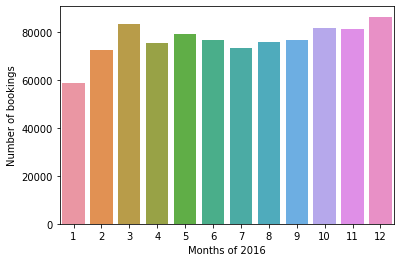

In [14]:
# We will only include the year 2016 since we don't have the data for all months in 2017
dfMaskMonth = df[df.year == 2016]

ax = sns.countplot(x='month', data=dfMaskMonth,)
ax.set(xlabel='Months of 2016', ylabel='Number of bookings')
plt.show()

###### As we can see, December has the highest number of bookings, but this might be inaccurate because it's only one year and the listings might've been unavailable in other months due to unknown reasons. 
###### This raisis two questions: 
##### 1 - Which month has the highest number of listings listed ?
##### 2 - Which month has the highest average of the number of bookings aginst the number of listings available?

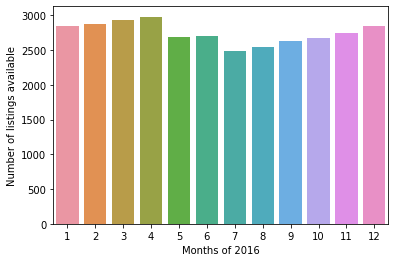

In [15]:
listingsOfMonth = pd.Series([2016])

for i in range(1,13):
    listingsOfMonth[i] = len(dfMaskMonth[dfMaskMonth['month'] == i]['listing_id'].unique())
listingsOfMonth.drop(0,inplace = True)


ax = sns.barplot(listingsOfMonth.index, listingsOfMonth.values)
ax.set(xlabel='Months of 2016', ylabel='Number of listings available')
plt.show()

#### As we can notice, April has the highest number of listings listed, while July has the lowest number.

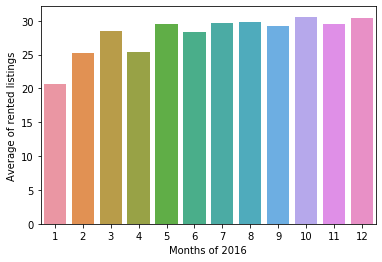

In [16]:
averagebookings = dfMaskMonth.month.value_counts(sort = False)/listingsOfMonth


ax = sns.barplot(averagebookings.index, averagebookings.values)
ax.set(xlabel='Months of 2016', ylabel='Average of rented listings')
plt.show()

##### October has the highest average of the number of bookings aginst the number of listings available and december is a close second. So we can see that the season for hosts starts from october and ends by the end of december

### Question 2:  What features have the highest impact on prices?

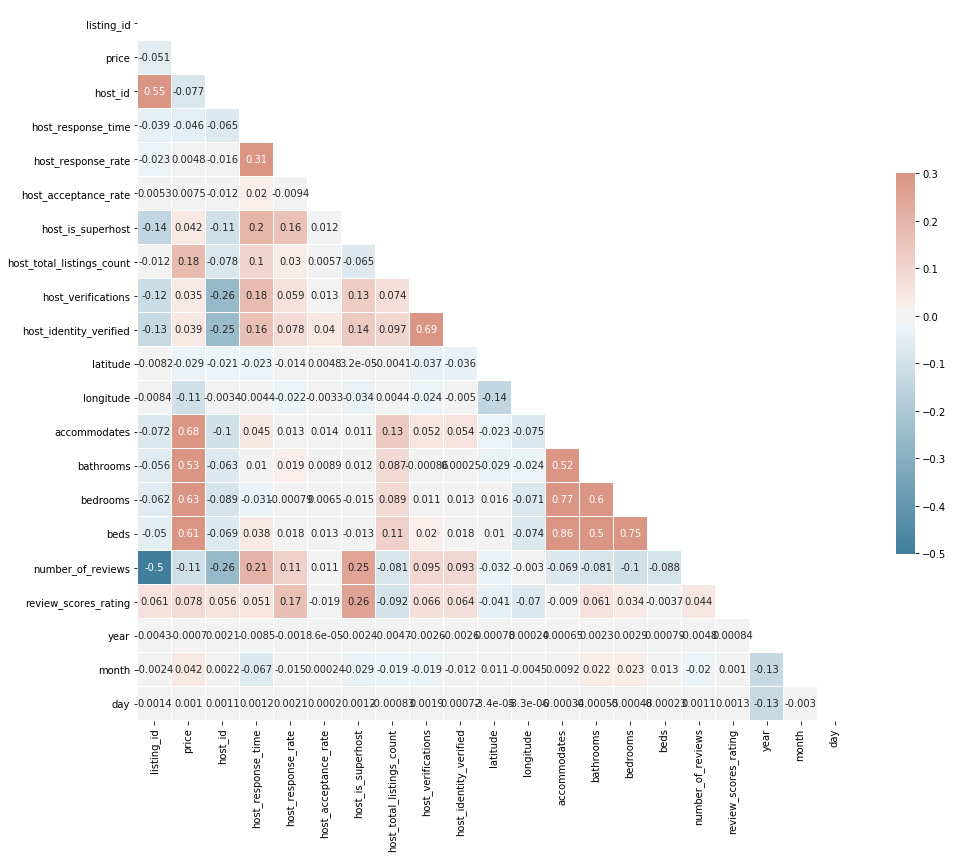

In [18]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 14))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = True)

#### The heatmap shows that accomodates, bathrooms, bedrooms, and beds hve the highest corrolation. Also those features have correlation between each other too. This makes sense since it's well-known that the price in real estates depends on the size of the property


#### Now I would like to invistigate whther those features affect the number of bookings for those properties and not only the price

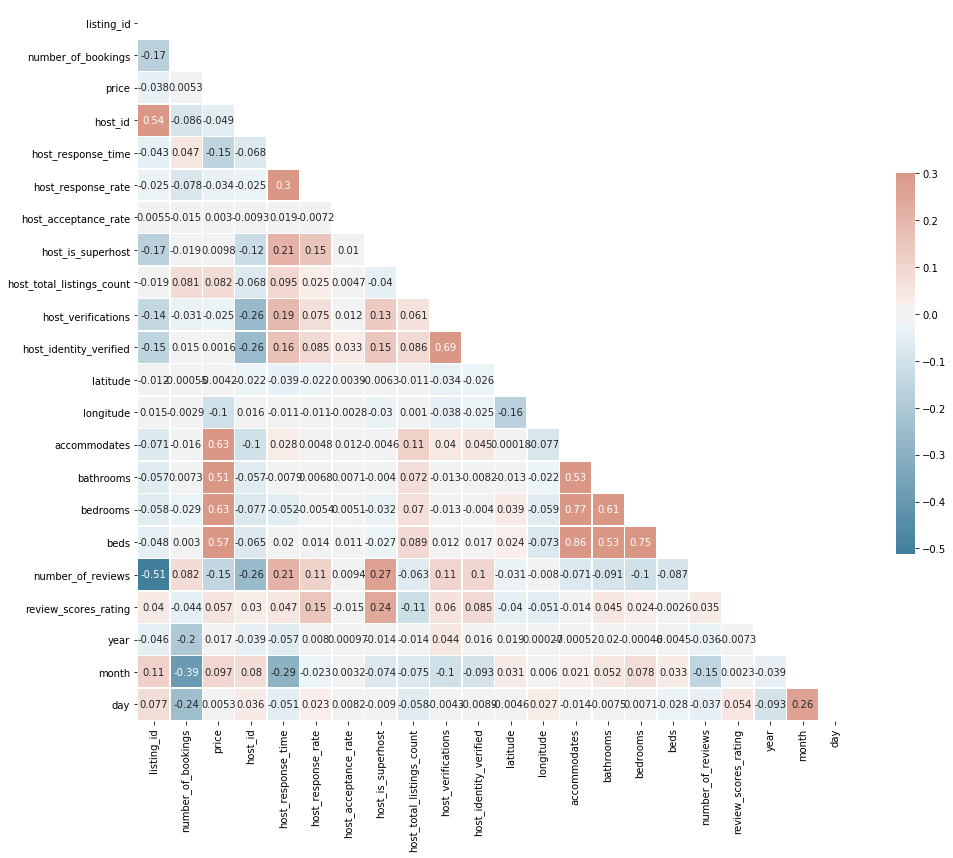

In [19]:
# Creat a df for the number of bookings for each listing id to merge
toMerge = df.listing_id.value_counts().reset_index()
# Creat a copy of the original df
df_copy = df.copy()
# drop duplicates of listing id to have unique rows
df_copy = df_copy.drop_duplicates(subset="listing_id")
# merge the two dfs
toMerge = toMerge.rename(index=str, columns={"listing_id":"number_of_bookings","index": "listing_id"})
df_copy = pd.merge( toMerge , df_copy, on = 'listing_id')

# Compute the correlation matrix
corr = df_copy.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 14))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = True)

#### The heatmap shows no sort of correlation between number of bookings and any features of the listings, but it shows that the number of booking is really dependent on the season as it correlates with the column month.



### Question 3: Which Amenities are the most important?

In [20]:
#We will create df of amenities dummies and merge them with our data sets to see what amenities have the higher impact

#Creat a copy of the original df
df_copy2 = df.copy()
#create dummies from the column amenities
df_copy2['amenities'] = df_copy2['amenities'].str.strip('{,}')

def Convert(string):
    ''' This functions takes a string, strips it from the double qoutation marks the splits it (by ',') into a list
    
    INPUT: String
    
    OUTPUT: A list with splitted items from the original string
    
    '''
    
    li = str(string).strip('"')
    li = string.split(",")
    return li
df_copy2['amenities'] = df_copy2['amenities'].apply(lambda row: Convert(row))
df_copy2 = df_copy2.join(df_copy2['amenities'].str.join(sep='*').str.get_dummies(sep='*'))
df_copy2.drop(axis = 1 , labels = 'amenities',inplace = True)

#drop irrelevant columns
df_copy2.drop(axis = 1, labels = ['host_id', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_total_listings_count', 'host_verifications',
       'host_identity_verified', 'neighbourhood', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'number_of_reviews', 'review_scores_rating',
       'cancellation_policy', 'year', 'month', 'day'],inplace = True)

In [55]:
df_copy2

,listing_id,date,price,neighbourhood_cleansed,"""24-Hour Check-in""","""Air Conditioning""","""Buzzer/Wireless Intercom""","""Cable TV""","""Carbon Monoxide Detector""","""Elevator in Building""",...,Gym,Hangers,Heating,Internet,Iron,Kitchen,Pool,Shampoo,TV,Washer
0,241032,2016-01-04,85.0,West Queen Anne,0,1,0,1,0,0,...,0,0,1,1,0,1,0,0,1,1
1,241032,2016-01-05,85.0,West Queen Anne,0,1,0,1,0,0,...,0,0,1,1,0,1,0,0,1,1
9,241032,2016-01-13,85.0,West Queen Anne,0,1,0,1,0,0,...,0,0,1,1,0,1,0,0,1,1
10,241032,2016-01-14,85.0,West Queen Anne,0,1,0,1,0,0,...,0,0,1,1,0,1,0,0,1,1
14,241032,2016-01-18,85.0,West Queen Anne,0,1,0,1,0,0,...,0,0,1,1,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1393207,10208623,2016-01-06,87.0,East Queen Anne,0,0,1,1,0,1,...,0,1,1,1,1,1,0,1,1,1
1393208,10208623,2016-01-07,87.0,East Queen Anne,0,0,1,1,0,1,...,0,1,1,1,1,1,0,1,1,1
1393211,10208623,2016-01-10,87.0,East Queen Anne,0,0,1,1,0,1,...,0,1,1,1,1,1,0,1,1,1
1393212,10208623,2016-01-11,87.0,East Queen Anne,0,0,1,1,0,1,...,0,1,1,1,1,1,0,1,1,1


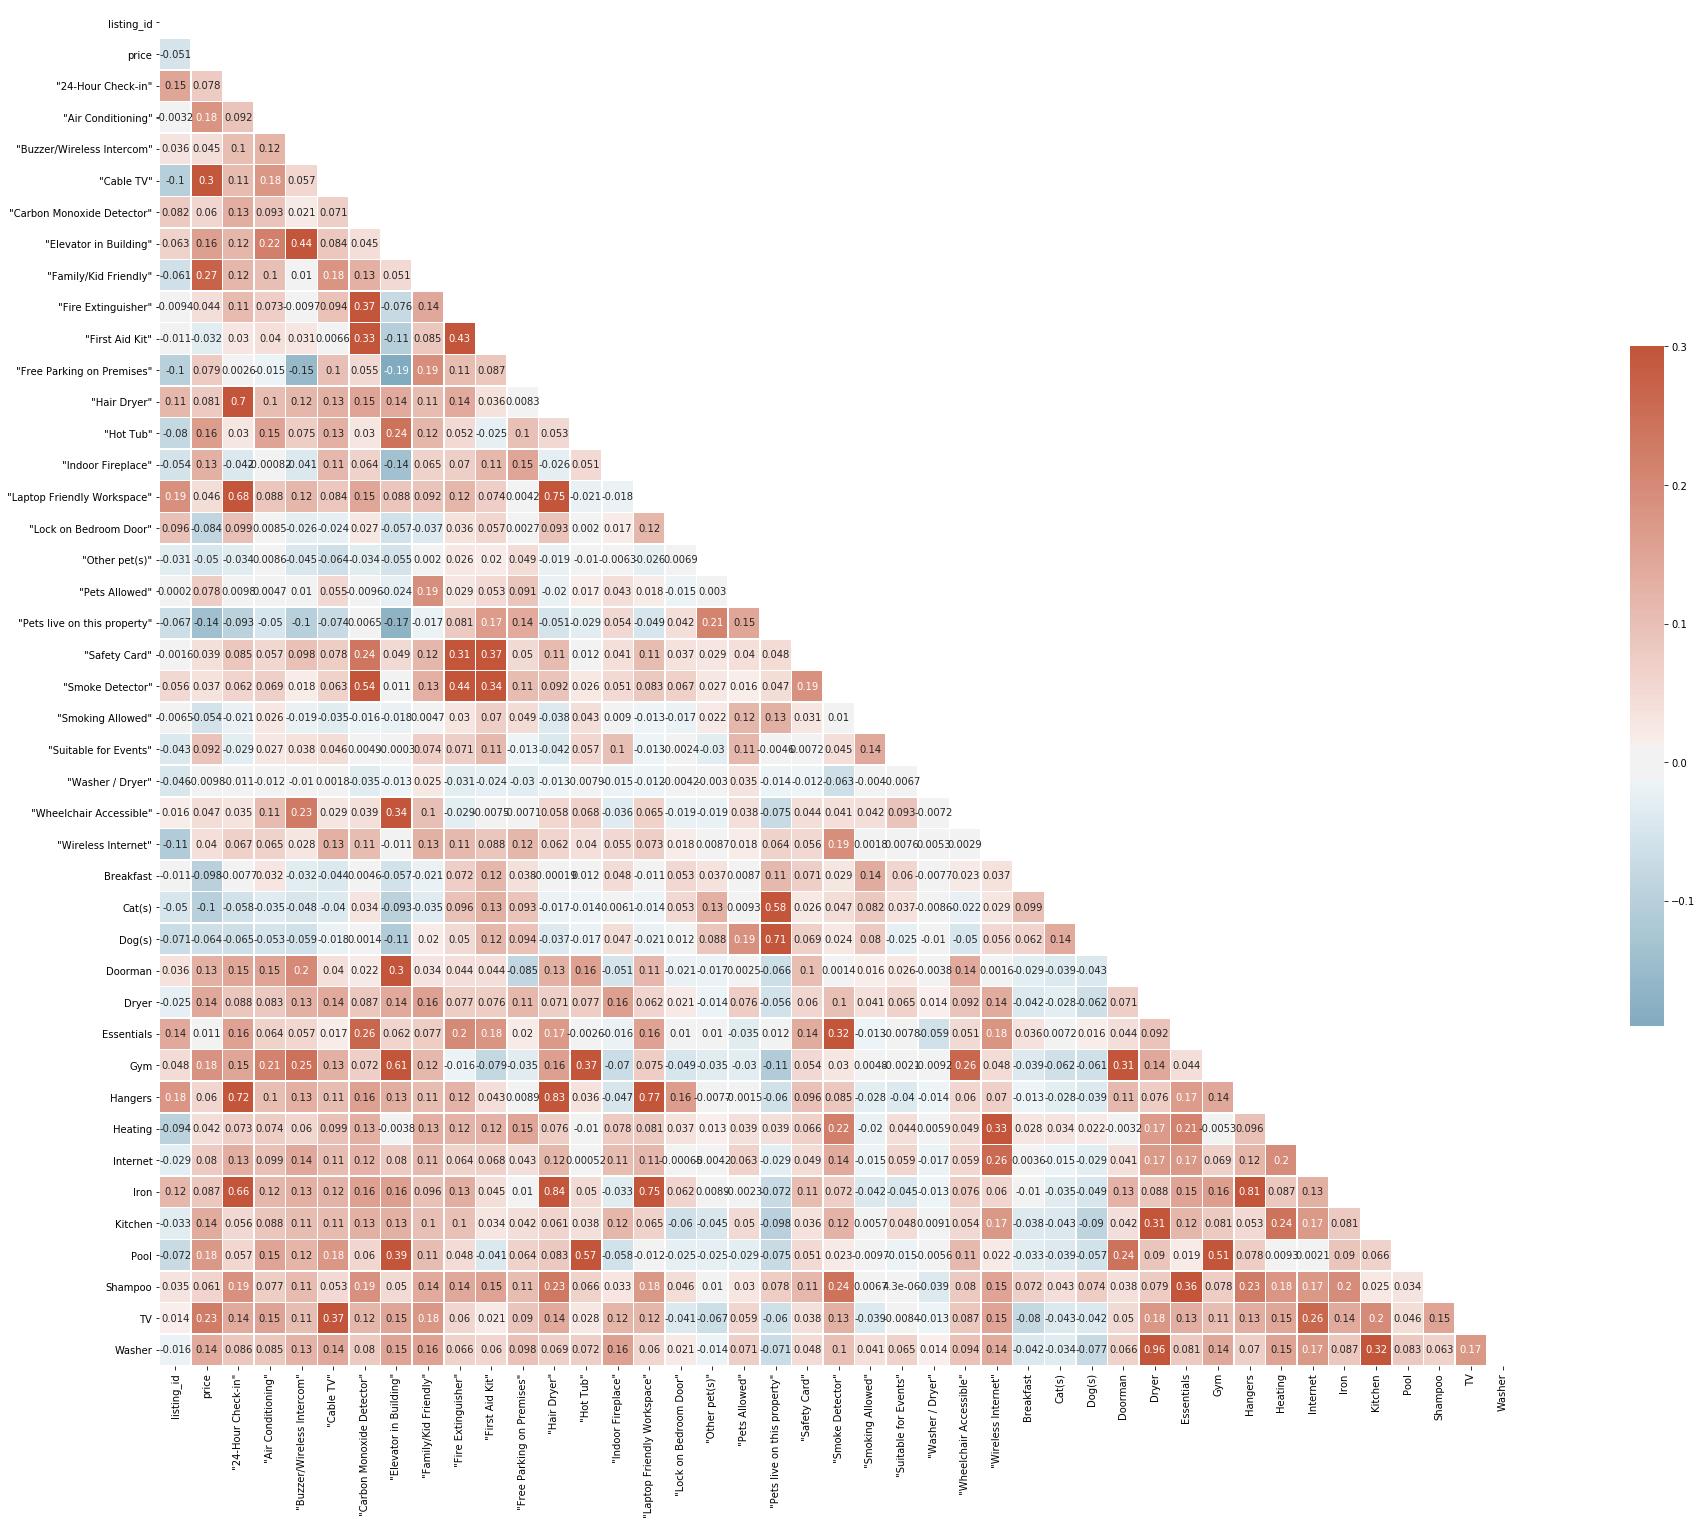

In [21]:
# Compute the correlation matrix
corr = df_copy2.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(40, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = True)

#### The heatmap shows that there are actually some interesting correlations, it suggests that capel tv and family/kid friendly features tend to have a dirctly propotional effect on the price, while having pets is indirectly propotional to the price.

### Question 4:  Can we tell if the reviewer is being unfair?

#### I will apply dictionary sentiment analysis technique to tell whether a reviewe is negative or positive then track the nature of each reviewer's comments and see the percentage of the negative reviews they posted compared to the positive once.

#### Any reviewer that has 50% or higher percentage of negative reviews, will be considred unfair.

#### I will exclude reviewers that have less than 4 comments

In [22]:
# We will use nltk vadar to label each comment if it is more likely to be negative or positive
# vadar will return a dictionary with the probability for each sentence and we will consider only the positive and negative
def posneg(sentence):
    ''' This function takes a dictionary and see if the values of two keys of the dictionary which are
    ('neg') and ('pos') then compares the two values and returns the string ('Negative') or ('Positive')
    
    INPUT: Dictionaty 
    
    OUTPUT: ('Negative') or ('Positive') '''

    if (sentence['neg'] > sentence['pos']) :
        return 'Negative'
    else:
        return 'Positive'
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
reviewsDf["sentiments"] = reviewsDf["comments"].apply(lambda x: sid.polarity_scores(x))
reviewsDf["sentiments"] = reviewsDf["sentiments"].apply(lambda x: posneg(x))

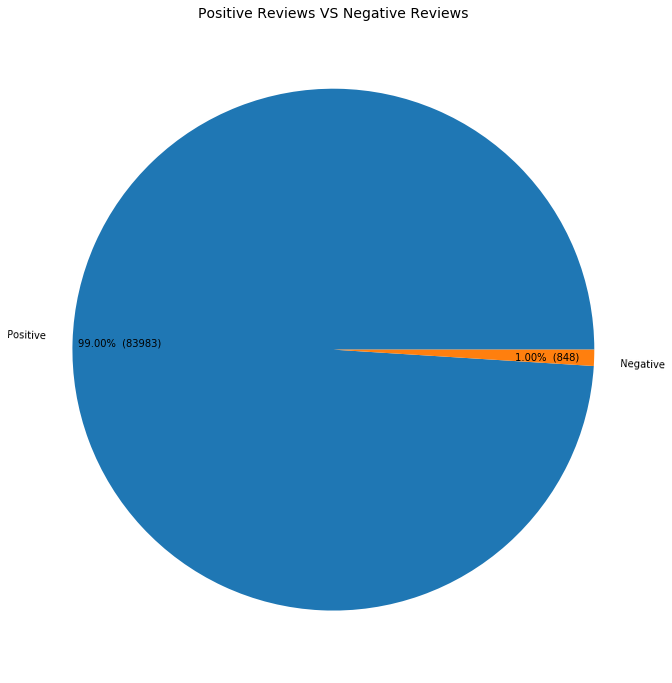

In [23]:
# Check how many negative reviews
reviewsDf.sentiments.value_counts()


def make_autopct(values):
    ''' These two functions takes the values of a desired data and supply to a pie chart the values 
    in which it can display both the percent value and the original value of the data
    
    INPUT: Valuse wished to graph
    
    OUTPUT: Both actual value and the percentage
    '''
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
#Using matplotlib
pie, ax = plt.subplots(figsize=[14,12])
labels = reviewsDf.sentiments.value_counts().keys()
plt.pie(x=reviewsDf.sentiments.value_counts(), autopct=make_autopct(reviewsDf.sentiments.value_counts().values), labels=labels, pctdistance=0.82,rotatelabels=True)
plt.title("Positive Reviews VS Negative Reviews", fontsize=14);


In [24]:
# delete comments that are not written in english
def isEnglish(s):
    '''This function takes a string an returns whether it was written in English or not
    
    INPUT: String
    
    OUTPUT: Boolean whether the string is English or not'''
    
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True
def english(sentence):
    ''' This function takes a string and calles the previous function (isEnglish), 
    it return 1 if the isEnglish function returns True and 0 otherwise
    
    INPUT: String
    OUTPUT: 1 or 0 '''
    
    if isEnglish(sentence):
        return 1
    else:
        return 0
reviewsDf['english'] = reviewsDf['comments'].apply(lambda x: english(x))
#Mask for only english comments
englishReviews = reviewsDf[reviewsDf['english'] == 1]



In [31]:
df_modeling = df.copy()

df_modeling = df_modeling.drop(columns = ['listing_id', 'year','day','date','neighbourhood_cleansed'])


df_modeling['amenities'] = df_modeling['amenities'].str.strip('{,}')
df_modeling['amenities'] = df_modeling['amenities'].apply(lambda row: Convert(row))
df_modeling = df_modeling.join(df_modeling['amenities'].str.join(sep='*').str.get_dummies(sep='*'))
df_modeling.drop(axis = 1 , labels = 'amenities',inplace = True)
df_modeling.dropna(inplace = True)
cat_columns = list(df_modeling.select_dtypes(include=['string','object']).columns)  
def Convert(string):
    li = str(string).strip('"')
    li = string.split(",")
    return li

for col in  cat_columns:
    df_modeling = pd.concat([df_modeling.drop(col, axis=1), pd.get_dummies(df_modeling[col], prefix=col, prefix_sep='_',

                                                         drop_first=True, dummy_na=True)], axis=1)





There are 516 reviewers who have more than 3 comments in the dataset
There are 0 customers who have more than 50% of negative comments


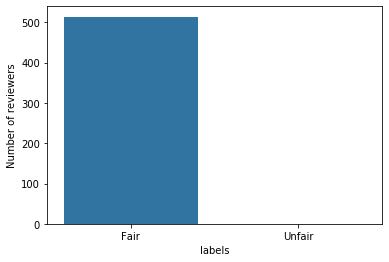

In [25]:
# How many customers have more more than 3 comments in the data set?
print('There are %d reviewers who have more than 3 comments in the dataset'%(englishReviews.reviewer_id.value_counts() > 3).sum())
# Masking for only those 515 reviewers
multipleReviews = englishReviews.reviewer_id.value_counts().index[0:514]
englishReviews = englishReviews[englishReviews['reviewer_id'].isin(multipleReviews)]
negativeReviews = englishReviews[englishReviews["sentiments"] == 0]

# How many customers can be considered unfair because they have more thnan 50% of their comments negative?
count = 0
for i in englishReviews['reviewer_id'].unique():
    if (((negativeReviews[negativeReviews['reviewer_id'] == i].shape[0])/(englishReviews[englishReviews['reviewer_id'] == i].shape[0])) >= 0.50):
        count += 1
print('There are %d customers who have more than 50%% of negative comments' % (count))


# Create a pie chart for the outcome 

x = ['Fair', 'Unfair']
y = np.array([514, 0])

ax = sns.barplot(x, y)

ax.set(xlabel='labels', ylabel='Number of reviewers')
plt.show()

#### So far we did not find any customer who tends to have a consistent behavior of posting negative comments.  This can show different results if we are provided with more data. 

#### The reviews data has a major issue, it cannot be linked to the listings and calendar data because all of the comments are before 2016 while the listings and calendar are after. This blockd us from asking many interesting questions such as How effective on the price is a negative review?

## Conclusion 

#### We analyzed the given Airbnb Seattle datasets which are Listings, Calendar of bookings, and Reviews. We found the months that have the highest number of bookings, the features that have the most significant impact on listings prices, the amenities that have the most significant impact on listings prices, and finally, we analyzed the reviews data to find out how many reviewers can be considered as unfair.

### Challenges:

#### The data recorded only the year 2016 which might result in bias when it comes to findings. Also, the review data didn't have reviews of 2016 which blocked us from finding some interesting insights like: How can a negative review affect the price? or How can a positive review incrases the bookings of a certain listing?
